# Project: Wrangling and Analyze Data

## Data Gathering
In the cell below, gather **all** three pieces of data for this project and load them in the notebook. **Note:** the methods required to gather each data are different.
1. Directly download the WeRateDogs Twitter archive data (twitter_archive_enhanced.csv)

In [226]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import requests
import tweepy 
import json
twitter_archive = pd.read_csv('twitter-archive-enhanced.csv')
twitter_archive.head(1)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None


2. Use the Requests library to download the tweet image prediction (image_predictions.tsv)

In [227]:
import requests
import os
    
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
response = requests.get(url)
with open(os.path.join(url.split('/')[-1]), mode = 'wb') as file:
    file.write(response.content)
image_pred=pd.read_csv('image-predictions.tsv',sep="\t")
image_pred.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


3. Use the Tweepy library to query additional data via the Twitter API (tweet_json.txt)

In [228]:
df_list = []
with open('tweet-json.txt') as file:
    for line in file:
        df_list.append(json.loads(line))

In [229]:
print(df_list[0])

{'created_at': 'Tue Aug 01 16:23:56 +0000 2017', 'id': 892420643555336193, 'id_str': '892420643555336193', 'full_text': "This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU", 'truncated': False, 'display_text_range': [0, 85], 'entities': {'hashtags': [], 'symbols': [], 'user_mentions': [], 'urls': [], 'media': [{'id': 892420639486877696, 'id_str': '892420639486877696', 'indices': [86, 109], 'media_url': 'http://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg', 'media_url_https': 'https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg', 'url': 'https://t.co/MgUWQ76dJU', 'display_url': 'pic.twitter.com/MgUWQ76dJU', 'expanded_url': 'https://twitter.com/dog_rates/status/892420643555336193/photo/1', 'type': 'photo', 'sizes': {'large': {'w': 540, 'h': 528, 'resize': 'fit'}, 'thumb': {'w': 150, 'h': 150, 'resize': 'crop'}, 'small': {'w': 540, 'h': 528, 'resize': 'fit'}, 'medium': {'w': 540, 'h': 528, 'resize': 'fit'}}}]}, 'extended_entities': {'media

In [230]:
tweet_data = pd.DataFrame(df_list, columns = ['id', 
                                              'retweet_count', 'favorite_count']) 

In [231]:
tweet_data.head(1)

,id,retweet_count,favorite_count
0,892420643555336193,8853,39467


In [232]:
tweet_data = tweet_data.rename(columns = {'id' : 'tweet_id'})
tweet_data.head(1)

,tweet_id,retweet_count,favorite_count
0,892420643555336193,8853,39467


## Assessing Data
In this section, detect and document at least **eight (8) quality issues and two (2) tidiness issue**. You must use **both** visual assessment
programmatic assessement to assess the data.

**Note:** pay attention to the following key points when you access the data.

* You only want original ratings (no retweets) that have images. Though there are 5000+ tweets in the dataset, not all are dog ratings and some are retweets.
* Assessing and cleaning the entire dataset completely would require a lot of time, and is not necessary to practice and demonstrate your skills in data wrangling. Therefore, the requirements of this project are only to assess and clean at least 8 quality issues and at least 2 tidiness issues in this dataset.
* The fact that the rating numerators are greater than the denominators does not need to be cleaned. This [unique rating system](http://knowyourmeme.com/memes/theyre-good-dogs-brent) is a big part of the popularity of WeRateDogs.
* You do not need to gather the tweets beyond August 1st, 2017. You can, but note that you won't be able to gather the image predictions for these tweets since you don't have access to the algorithm used.



In [233]:
#checking the overall Data visually..
twitter_archive.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [234]:
twitter_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [235]:
twitter_archive.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [236]:
#looking at the max and min data for errors looks like some numerators does'nt make sense.
twitter_archive.rating_numerator.describe()

count    2356.000000
mean       13.126486
std        45.876648
min         0.000000
25%        10.000000
50%        11.000000
75%        12.000000
max      1776.000000
Name: rating_numerator, dtype: float64

In [237]:
#number of numerators less than 10.
twitter_archive[twitter_archive.rating_numerator <10].count()[0]

440

In [238]:
#Ids of numerators less than 10 there are 440 of them
twitter_archive[twitter_archive.rating_numerator <10].tweet_id

45      883482846933004288
229     848212111729840128
315     835152434251116546
387     826598799820865537
462     817502432452313088
485     814578408554463233
599     798682547630837760
605     798576900688019456
730     781661882474196992
745     780092040432480260
764     777953400541634568
765     777885040357281792
784     775096608509886464
814     771014301343748096
835     768193404517830656
845     766423258543644672
859     763183847194451968
860     763167063695355904
883     760252756032651264
896     759099523532779520
906     758041019896193024
912     757596066325864448
915     757354760399941633
936     753375668877008896
946     752568224206688256
948     752334515931054080
956     751583847268179968
964     750506206503038976
966     750383411068534784
987     749036806121881602
               ...        
2312    666776908487630848
2314    666701168228331520
2315    666691418707132416
2316    666649482315059201
2317    666644823164719104
2319    666447344410484738
2

In [239]:
#Looking at the denominators now.
twitter_archive.rating_denominator.describe()

count    2356.000000
mean       10.455433
std         6.745237
min         0.000000
25%        10.000000
50%        10.000000
75%        10.000000
max       170.000000
Name: rating_denominator, dtype: float64

In [240]:
#Looks like we even have an id with 0 denominator.
twitter_archive[twitter_archive.rating_denominator ==0].tweet_id

313    835246439529840640
Name: tweet_id, dtype: int64

In [241]:
twitter_archive[twitter_archive.rating_denominator ==170].tweet_id

1120    731156023742988288
Name: tweet_id, dtype: int64

In [242]:
twitter_archive[twitter_archive.rating_denominator !=10].count()[0]

23

### Now Let's Look at the image predictions Data.

In [243]:
image_pred.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [244]:
image_pred.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [245]:
image_pred.sample(15)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
1456,777641927919427584,https://pbs.twimg.com/media/CmoPdmHW8AAi8BI.jpg,1,golden_retriever,0.964929,True,Labrador_retriever,0.011584,True,refrigerator,0.007499,False
1611,801285448605831168,https://pbs.twimg.com/media/Cx683NPUAAAjyU4.jpg,1,minivan,0.789376,False,beach_wagon,0.081125,False,convertible,0.064534,False
159,668892474547511297,https://pbs.twimg.com/media/CUhiJ63WEAAw2qm.jpg,1,kelpie,0.421979,True,collie,0.227060,True,Cardigan,0.168211,True
1091,719367763014393856,https://pbs.twimg.com/media/Cfu1KSRXEAACC5X.jpg,1,swing,0.171486,False,soft-coated_wheaten_terrier,0.050971,True,Tibetan_terrier,0.047759,True
442,674632714662858753,https://pbs.twimg.com/media/CVzG3yOVAAAqi9I.jpg,1,jellyfish,0.432748,False,goldfish,0.113111,False,coral_reef,0.087047,False
1523,788150585577050112,https://pbs.twimg.com/media/CvASw6dWcAQmo3X.jpg,3,chow,0.814145,True,Pomeranian,0.112704,True,Chihuahua,0.015883,True
1766,826848821049180160,https://pbs.twimg.com/media/C3mOnZ_XUAAjr2V.jpg,4,Great_Pyrenees,0.858764,True,golden_retriever,0.023526,True,Pekinese,0.017104,True
385,673345638550134785,https://pbs.twimg.com/media/CVg0SVRWEAAsBrS.jpg,1,hamster,0.761025,False,weasel,0.069362,False,Pomeranian,0.064627,True
1129,728015554473250816,https://pbs.twimg.com/media/ChpuRyvVAAARMoq.jpg,1,cocker_spaniel,0.384559,True,golden_retriever,0.091661,True,sandbar,0.081799,False
778,689877686181715968,https://pbs.twimg.com/media/CZLwGAIWQAIYsTx.jpg,1,Old_English_sheepdog,0.269155,True,Tibetan_terrier,0.111496,True,Lakeland_terrier,0.104939,True


In [246]:
#a lot of the info are'nt even dogs based on the image predictions neural network
image_pred[image_pred.p1_dog == False].count()[0]

543

### Looking at the Twitter API Data

In [247]:
tweet_data.head()

,tweet_id,retweet_count,favorite_count
0,892420643555336193,8853,39467
1,892177421306343426,6514,33819
2,891815181378084864,4328,25461
3,891689557279858688,8964,42908
4,891327558926688256,9774,41048


In [248]:
tweet_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 3 columns):
tweet_id          2354 non-null int64
retweet_count     2354 non-null int64
favorite_count    2354 non-null int64
dtypes: int64(3)
memory usage: 55.2 KB


In [249]:
tweet_data.describe()

,tweet_id,retweet_count,favorite_count
count,2.354000e+03,2354.000000,2354.000000
mean,7.426978e+17,3164.797366,8080.968564
std,6.852812e+16,5284.770364,11814.771334
min,6.660209e+17,0.000000,0.000000
25%,6.783975e+17,624.500000,1415.000000
50%,7.194596e+17,1473.500000,3603.500000
75%,7.993058e+17,3652.000000,10122.250000
max,8.924206e+17,79515.000000,132810.000000


### Quality issues
1. ##### Some names show no values and other a single letter like 'a' for ex.

2. ##### 440 numerators are less than 10.

3. ##### A lot of columns doesn't benefit our Analysis and needs to be removed like reply_to_status_id.

4. ##### Some Rows have a denominator of 0 others of 170.

5. ##### Fixing expanded URLs and Timestamps.

6. ##### Missing ids for the image pred data frame, 2075 should be 2356.

7. ##### Lower and Upper cases inconsistency in the Pnames columns.

8. ##### Using ' ' instead of '_' in Names.

9. ##### Missing 2 values in the Twitter API data frame showing 2354 instead of 2356.

10. ##### Removing Retweets row.

11. ##### Changing tweet_id from int to str.

12. ##### Removing images that are predicted false.

### Tidiness issues
1. ##### Dog Stages should be grouped together in one column

2. ##### Data are found in seperate DFs and need to be combined into one based on tweet_id

## Cleaning Data
In this section, clean **all** of the issues you documented while assessing. 

**Note:** Make a copy of the original data before cleaning. Cleaning includes merging individual pieces of data according to the rules of [tidy data](https://cran.r-project.org/web/packages/tidyr/vignettes/tidy-data.html). The result should be a high-quality and tidy master pandas DataFrame (or DataFrames, if appropriate).

In [250]:
# Make copies of original pieces of data
twitter_archive_clean = twitter_archive.copy()
image_pred_clean = image_pred.copy()
tweet_data_clean = tweet_data.copy()

In [251]:
twitter_archive_clean.head(1)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None


In [252]:
image_pred_clean.head(1)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True


In [253]:
tweet_data_clean.head()

,tweet_id,retweet_count,favorite_count
0,892420643555336193,8853,39467
1,892177421306343426,6514,33819
2,891815181378084864,4328,25461
3,891689557279858688,8964,42908
4,891327558926688256,9774,41048


### Tidiness Issue #1:

#### Define: Grouping Dog Stage Data into a single column.

#### Code

In [254]:
twitter_archive_clean['dog_stage'] = twitter_archive['text'].str.extract('(doggo|floofer|pupper|puppo)')

In [255]:
twitter_archive_clean.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,dog_stage
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None,NaN
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None,NaN
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None,NaN
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None,NaN
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None,NaN


In [256]:
#now deleting the old columns..
twitter_archive_clean.drop(columns = ['doggo', 'floofer', 'pupper', 'puppo'])

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,dog_stage
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,NaN
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,NaN
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,NaN
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,NaN
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,NaN
5,891087950875897856,NaN,NaN,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891087950...,13,10,None,NaN
6,890971913173991426,NaN,NaN,2017-07-28 16:27:12 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jax. He enjoys ice cream so much he gets ...,NaN,NaN,NaN,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",13,10,Jax,NaN
7,890729181411237888,NaN,NaN,2017-07-28 00:22:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When you watch your owner call another dog a g...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890729181...,13,10,None,NaN
8,890609185150312448,NaN,NaN,2017-07-27 16:25:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Zoey. She doesn't want to be one of th...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890609185...,13,10,Zoey,NaN
9,890240255349198849,NaN,NaN,2017-07-26 15:59:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890240255...,14,10,Cassie,doggo


### Tidiness Issue #2:

#### Define: Merging the DataFrames in one DF based on tweet_id column.

#### Code

In [257]:
twitter_archive_clean = pd.merge(twitter_archive_clean, tweet_data_clean, on = 'tweet_id', how = 'left')
twitter_archive_clean = pd.merge(twitter_archive_clean, image_pred_clean, on = 'tweet_id', how = 'left')

#### Test

In [258]:
twitter_archive_clean.head(0)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog


### Quality Issue - Removing Rts.

In [259]:
twitter_archive_clean = twitter_archive_clean[twitter_archive_clean.retweeted_status_id.isnull()]

In [260]:
twitter_archive_clean = twitter_archive_clean.drop(columns = ['retweeted_status_id', 'retweeted_status_user_id',
                                                              'retweeted_status_timestamp'])

In [261]:
twitter_archive_clean.head(0)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,...,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog


### Quality Issue -  Changing Tweet_Id from int64 to str..

In [262]:
twitter_archive_clean['tweet_id'] = twitter_archive_clean['tweet_id'].astype(str)
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 28 columns):
tweet_id                 2175 non-null object
in_reply_to_status_id    78 non-null float64
in_reply_to_user_id      78 non-null float64
timestamp                2175 non-null object
source                   2175 non-null object
text                     2175 non-null object
expanded_urls            2117 non-null object
rating_numerator         2175 non-null int64
rating_denominator       2175 non-null int64
name                     2175 non-null object
doggo                    2175 non-null object
floofer                  2175 non-null object
pupper                   2175 non-null object
puppo                    2175 non-null object
dog_stage                364 non-null object
retweet_count            2175 non-null float64
favorite_count           2175 non-null float64
jpg_url                  1994 non-null object
img_num                  1994 non-null float64
p1                   

### Quality Issue -  Fixing Dog names.

In [263]:
#Using Regex expression to get lower and None values..
twitter_archive_clean.name = twitter_archive_clean.name.str.replace('^[a-z]+', 'None')

In [264]:
twitter_archive_clean['name'].value_counts()

None            784
Lucy             11
Charlie          11
Cooper           10
Oliver           10
Penny             9
Tucker            9
Sadie             8
Lola              8
Winston           8
Daisy             7
Toby              7
Jax               6
Stanley           6
Bella             6
Oscar             6
Bo                6
Bailey            6
Koda              6
Dave              5
Leo               5
Bentley           5
Milo              5
Rusty             5
Scout             5
Chester           5
Buddy             5
Louis             5
Clark             4
Clarence          4
               ... 
Humphrey          1
Paull             1
Brat              1
Tessa             1
Aqua              1
Balto             1
Willem            1
Brockly           1
Covach            1
Chloe             1
Molly             1
Strider           1
Evy               1
Ester             1
Jareld            1
Jackie            1
Juckson           1
Beckham           1
Bert              1


### Quality Issue -  Fixing Ratings using Regex Extract.

In [265]:
ratings = twitter_archive_clean.text.str.extract('((?:\d+\.)?\d+)\/(\d+)', expand=True)
twitter_archive_clean.rating_numerator = ratings

In [266]:
twitter_archive_clean.sample(20)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,...,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
1685,681654059175129088,NaN,NaN,2015-12-29 01:52:46 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Toffee. He's a happy pupper. Appears d...,https://twitter.com/dog_rates/status/681654059...,12,10,Toffee,...,1.0,Pomeranian,0.800538,True,chow,0.146892,True,Pekinese,0.037613,True
287,838561493054533637,NaN,NaN,2017-03-06 01:26:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Walter. His owner has been watching al...,https://twitter.com/dog_rates/status/838561493...,13,10,Walter,...,1.0,kelpie,0.216562,True,doormat,0.139994,False,dalmatian,0.132820,True
1309,707059547140169728,NaN,NaN,2016-03-08 04:25:07 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Say hello to Cupcake. She's an Icelandic Dippe...,https://twitter.com/dog_rates/status/707059547...,11,10,Cupcake,...,1.0,Samoyed,0.897312,True,Great_Pyrenees,0.039180,True,kuvasz,0.019516,True
512,811744202451197953,NaN,NaN,2016-12-22 01:24:33 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Halo. She likes watermelon. 13/10 http...,https://twitter.com/dog_rates/status/811744202...,13,10,Halo,...,1.0,Pekinese,0.386082,True,Labrador_retriever,0.202862,True,golden_retriever,0.170487,True
1156,724771698126512129,NaN,NaN,2016-04-26 01:26:53 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Nothin better than a doggo and a sunset. 11/10...,https://twitter.com/dog_rates/status/724771698...,11,10,None,...,2.0,German_short-haired_pointer,0.835491,True,bluetick,0.058788,True,English_setter,0.037208,True
559,803276597545603072,NaN,NaN,2016-11-28 16:37:19 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Winston. His selfie game is legendary....,https://twitter.com/dog_rates/status/803276597...,11,10,Winston,...,1.0,Pembroke,0.457086,True,chow,0.307801,True,golden_retriever,0.049988,True
2229,668248472370458624,NaN,NaN,2015-11-22 02:03:45 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Say hello to Bisquick. He is a Brown Douglass ...,https://twitter.com/dog_rates/status/668248472...,8,10,Bisquick,...,1.0,Chihuahua,0.734547,True,miniature_pinscher,0.068294,True,toy_terrier,0.046367,True
1041,743980027717509120,NaN,NaN,2016-06-18 01:33:55 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Geno. He's a Wrinkled Baklavian Velvee...,https://twitter.com/dog_rates/status/743980027...,11,10,Geno,...,1.0,bull_mastiff,0.975730,True,Rhodesian_ridgeback,0.008073,True,pug,0.005571,True
1596,686286779679375361,NaN,NaN,2016-01-10 20:41:33 +0000,"<a href=""http://vine.co"" rel=""nofollow"">Vine -...",When bae calls your name from across the room....,https://vine.co/v/iMZx6aDbExn,12,10,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1764,678424312106393600,NaN,NaN,2015-12-20 03:58:55 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Crystal. She's a shitty fireman. No se...,https://twitter.com/dog_rates/status/678424312...,2,10,Crystal,...,1.0,Maltese_dog,0.759945,True,toy_poodle,0.101194,True,Shih-Tzu,0.056037,True


### Quality Issue -  Dropping expanded Url and timestamps.

In [267]:
twitter_archive_clean=twitter_archive_clean.drop(columns=['timestamp','expanded_urls'])

In [268]:
twitter_archive_clean.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,source,text,rating_numerator,rating_denominator,name,doggo,floofer,...,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,892420643555336193,NaN,NaN,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,13,10,Phineas,None,None,...,1.0,orange,0.097049,False,bagel,0.085851,False,banana,0.076110,False
1,892177421306343426,NaN,NaN,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,13,10,Tilly,None,None,...,1.0,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True
2,891815181378084864,NaN,NaN,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,12,10,Archie,None,None,...,1.0,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
3,891689557279858688,NaN,NaN,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,13,10,Darla,None,None,...,1.0,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False
4,891327558926688256,NaN,NaN,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,12,10,Franklin,None,None,...,2.0,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True


### Quality issue - Missing ids for the image pred data frame, 2075 should be 2356

In [269]:
twitter_archive_clean = twitter_archive_clean[twitter_archive_clean.jpg_url.notnull()]

In [270]:
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1994 entries, 0 to 2355
Data columns (total 26 columns):
tweet_id                 1994 non-null object
in_reply_to_status_id    23 non-null float64
in_reply_to_user_id      23 non-null float64
source                   1994 non-null object
text                     1994 non-null object
rating_numerator         1994 non-null object
rating_denominator       1994 non-null int64
name                     1994 non-null object
doggo                    1994 non-null object
floofer                  1994 non-null object
pupper                   1994 non-null object
puppo                    1994 non-null object
dog_stage                326 non-null object
retweet_count            1994 non-null float64
favorite_count           1994 non-null float64
jpg_url                  1994 non-null object
img_num                  1994 non-null float64
p1                       1994 non-null object
p1_conf                  1994 non-null float64
p1_dog             

### Quality issue -  Lower and Upper cases inconsistency in the Pnames columns.

In [271]:
twitter_archive_clean.p1 = twitter_archive_clean.p1.str.title()
twitter_archive_clean.p2 = twitter_archive_clean.p2.str.title()
twitter_archive_clean.p3 = twitter_archive_clean.p3.str.title()

In [272]:
twitter_archive_clean.p1.head()

0         Orange
1      Chihuahua
2      Chihuahua
3    Paper_Towel
4         Basset
Name: p1, dtype: object

### Quality issue -  Using ' ' instead of '_' in Names.

In [273]:
twitter_archive_clean.p1 = twitter_archive_clean.p1.str.replace('_', ' ')
twitter_archive_clean.p2 = twitter_archive_clean.p2.str.replace('_', ' ')
twitter_archive_clean.p3 = twitter_archive_clean.p3.str.replace('_', ' ')

In [274]:
twitter_archive_clean.p1.head()

0         Orange
1      Chihuahua
2      Chihuahua
3    Paper Towel
4         Basset
Name: p1, dtype: object

### Quality issue - Missing 2 values in the Twitter API data frame showing 2354 instead of 2356.


In [275]:
sum(twitter_archive_clean.retweet_count.isnull())

0

## Storing Data
Save gathered, assessed, and cleaned master dataset to a CSV file named "twitter_archive_master.csv".

In [276]:
twitter_archive_clean.to_csv('twitter_archive_master.csv',index=False)

## Analyzing and Visualizing Data
In this section, analyze and visualize your wrangled data. You must produce at least **three (3) insights and one (1) visualization.**

### Insights:
1. Doggo is the most common stage name.

2. Floofer is the least common stage name.

3. There's a linear relationshiop between retweet and favorites count.

4. Most common Dog name was Cooper and Lucy

### Visualization

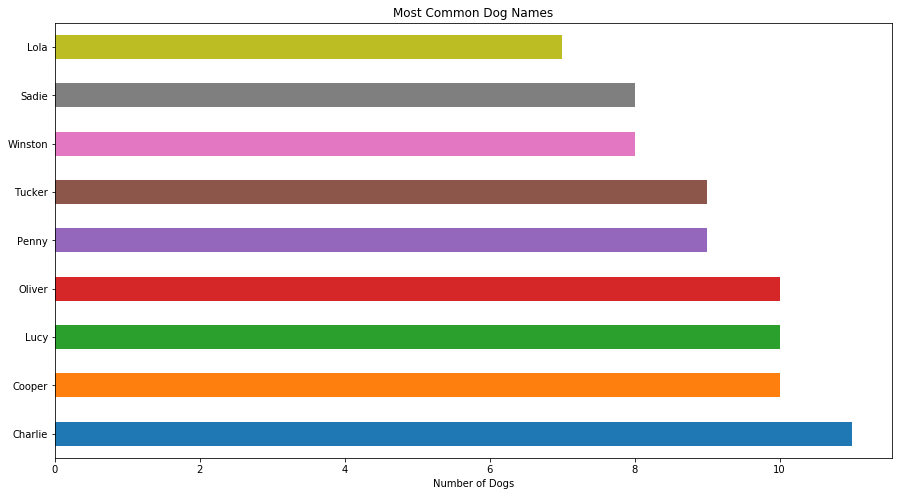

In [288]:
twitter_archive_clean.name.value_counts()[1:10].plot('barh', figsize=(15,8), title='Most Common Dog Names').set_xlabel("Number of Dogs");

(Text(0.5,0,'retweet_count'), Text(0,0.5,'favorite_count'))

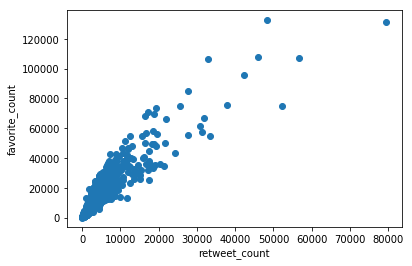

In [277]:
plt.scatter(twitter_archive_clean.retweet_count, twitter_archive_clean.favorite_count)
plt.xlabel('retweet_count'), plt.ylabel('favorite_count')

#### The Linear Relationship between Retweets and Favorites

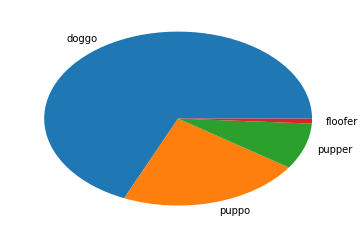

In [278]:
labels=twitter_archive_clean.dog_stage.unique()
plt.pie(twitter_archive_clean.dog_stage.value_counts(),labels=labels[1:]);

##### Doggo is the most common Stage name.

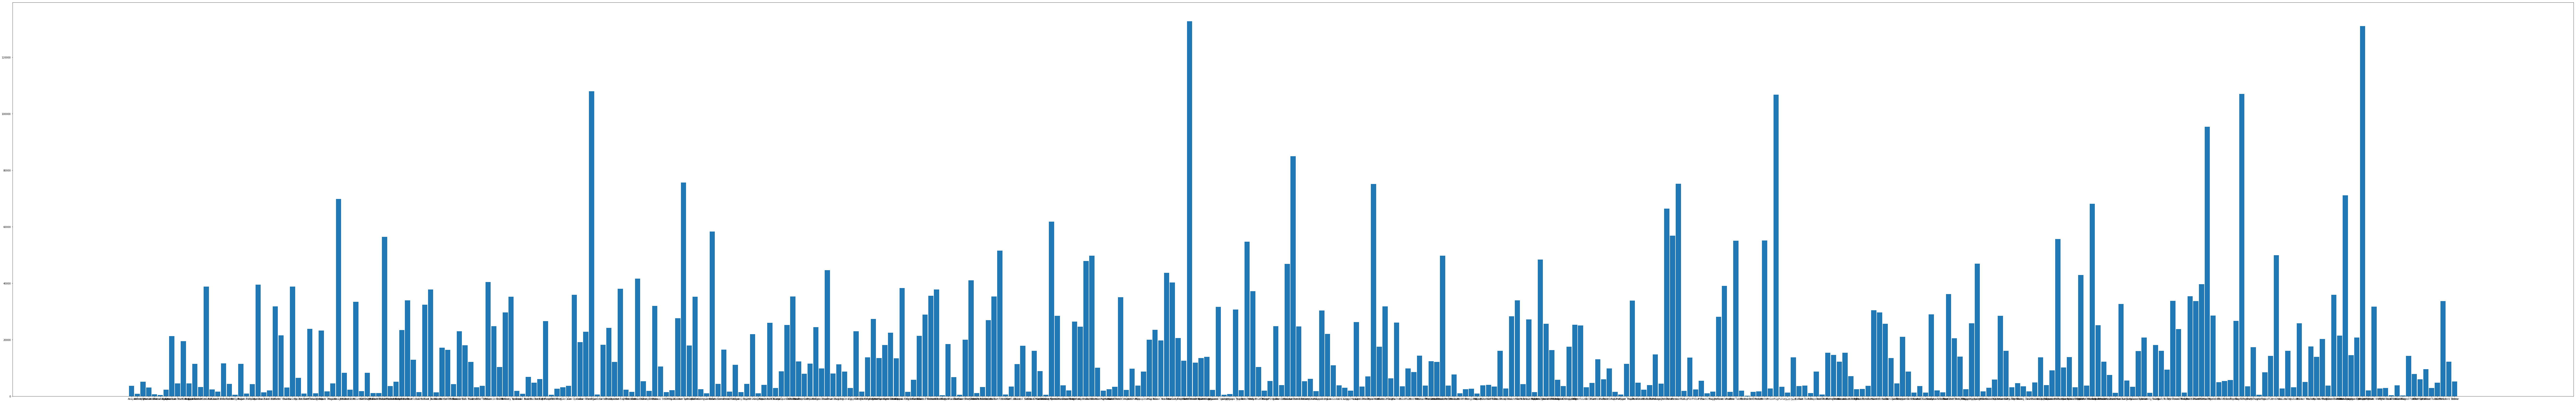

In [279]:
plt.subplots(figsize=(190,30))
plt.bar(twitter_archive_clean.p3,twitter_archive_clean.favorite_count,width= 0.9);